트레인데이터의 y값의 숫자를 키워서 인위적으로 가중치를 줄수 있나???

젠터 데이터 보고 남녀비율, 나리 비율 따져서 등록 자동차수의 차이가 있을수 있나....어느 연령대의 어느 성별이 두드러지게 차량보유가 많고, 이 비율이 높은 지역이 역시 가중치를 받게 할수 있나. 
상점이 들어있는 데이터의 등록차량수가 의도적으로 낮게 집계된다. 상점 없는 곳의 등록차량수/총세대수 로 %비교해서 가중치 줄수 있으면 가중치 주자.

# 목차 

### 1. 들어가는 말

1)데이터 선정 이유 및 문제 정의

2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

### 2. 데이터처리 및 분석 

1) EDA와 데이터 전처리

2) 예측

예측1: 다중선형회귀분석

예측2: ridge-regression

예측3: RandomForest

예측4: xgboost
  
3) 분석요약

### 3. 결과 해석 및 평가
  
  1) 충격과 공포의 참담한 결과지만...
  
  2) 머신러닝 모델 해석
  
### 4. 결어

# 1. 들어가는 말

1) 데이터 선정 이유 및 문제 정의

프로젝트+경진대회 = 일타쌍피, 일석이조

 옛날 말씀에 누이좋고 매부 좋다. 도랑치고 가재잡는다고도 하였고, 근래에는 무한도전의 노홍철씨가 알래스카에서 잡은 작은 송사리를 방생하며 "놔 줄테니까 부모님 모시고 와"라는 어록을 남겼다. 

단도직입적으로 말하면 기왕 프로젝트를 만드는 김에 경진대회도 나가보는 일타쌍피의 기회를 갖고 싶었다. 물론 학습 취지에는 약간 부합하지 않는 데이터지만, 데이터 수집에 관한 고민은 크롤링이나 데이터베이스 관련 이론을 배운 후에 해도 늦지 않을 거라 판단하여 데이터 수집의 단계는 과감히 생략하고 바로 경진대회 데이터를 사용하기로 했다. 

 사용한 데이터는 존경과 사모해 마지 않는 '재테크의 정석' 대한토지주택공사의  '주차수요 예측 AI 경진대회'의 data이며, 
주제는 <유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측>하는 것이다. 


해당 유형은 미래의 주차수요를 예측하는 문제로 '회귀'로 접근해야 한다고 판단하였다. 

2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

주어진 데이터를 쓰는 것이기 때문에 주제와 이를 뒷받침하는 가설을 따로 설정하지 않았다!!!! 

다만 평가 지표는 MAE(Mean Absolute Error)이다. 절대값으로 예상과 실제와의 차이를 직관적으로 알수 있으므로 이 수치를 제시한것으로 보인다. 
물론 주어진 데이터 외에도 주차수요와 상관관계를 가질 수 있는 여러 데이터가 있을 수 있으므로 차후 추가적인 조사를 계속 해 나갈 생각이다. 

타겟은 '등록차량수'로 잡았다. 차량수를 기반으로 주차공간을 만들것이기 때문이다. 

베이스라인 모델은 랜덤포레스트로 잡혀있다. 자료를 대충 봤는데 자료의 피쳐들과 타겟과의 상관관계가 잘 잡히지 않으므로 주최측에서 랜덤포레스트로 베이스라인을 잡은것으로 추측했다.



#  2. 데이터처리 및 분석 

## 1) EDA 및 전처리

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 데이터 불러오기

In [2]:
url_train = "https://raw.githubusercontent.com/ZeusKwon/data-drive/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94/train.csv"
url_test = "https://raw.githubusercontent.com/ZeusKwon/data-drive/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94/test.csv"
url_submission = "https://raw.githubusercontent.com/ZeusKwon/data-drive/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94/sample_submission.csv"
urlinfo = 'https://raw.githubusercontent.com/ZeusKwon/data-drive/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94/age_gender_info.csv'

target = '등록차량수'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)
submission = pd.read_csv(url_submission)
age_gender_info = pd.read_csv(urlinfo)

## 용어정리 및 가정 정립

### 용어정리
전용면적: 전용면적은 아파트에서 실제생활하는 공간인 곳으로 방, 거실, 화장실, 주방 등을 포함한 내부면적입니다. 여기서 발코니는 전용면적에서 제외되며 발코니 확장에 따른 면적이 넓어 질 수 있습니다. 전용면적은 아파트 청약시 주택타입의 기준이되며 등기부등본에 기재되어 과세 표준으로 쓰입니다. 따라서 전용면적에 따라서 집의 크기가 달라보이기 때문에 전용면적을 유심시 봐야합니다. https://eastsky3483.tistory.com/167

국민임대주택제도는 나무위키 참조: https://namu.wiki/w/%EA%B5%AD%EB%AF%BC%EC%9E%84%EB%8C%80%EC%A3%BC%ED%83%9D

행복주택: 기본적으로 행복주택은 국민임대주택의 하위 분류로, 일반적인 사항은 국민임대주택과 크게 다르지 않다. 그러나 국민임대주택이 일반 국민들과 사회적 약자층을 대상으로 하는 것과 달리 행복주택은 대학생, 사회초년생, 그리고 신혼부부로 입주대상을 한정하고 있기 때문에 세부적인 부분에서 다소 차이가 있다.

--> 행복주택 단점: 협소한 주차공간

기본적으로 작은 부지에 작은 크기의 방을 최대한으로 때려넣는 식으로 지어지는 행복주택이기 때문에 부지 대비 가구의 수가 굉장히 많으며, 사람은 많은데 부지는 작으니 개개인에게 할당되는 주차공간도 굉장히 적다. 때문에 대학생이나 사회초년생은 아예 차를 소유하지 않을 것을 입주 조건으로 내놓는 경우까지 생긴다. 카셰어링 등을 적극 도입하여 문제를 완충해보려는 노력을 하긴 하지만 차를 가지고 있더라도 행복주택에서 활용하는게 쉽진 않다.

---> 이게 데이터에 반영되있는지 확인이 필요하다. 행복주택이 상대적으로 차량등록수가 적은지.


## '유형별 공급' 피쳐의 구성
국민임대/장기전세

(일반)해당지역 거주 무주택세대구성원
(특별/우선)3자녀 이상 가구
(특별/우선)국가유공자
(특별/우선)영구임대 입주자
(특별/우선)비닐간이공작물 거주자
(특별/우선)신혼부부(혼인기간 5년이내)
(특별/우선)사업지구 철거민
(특별/우선)기타 공급대상(고령자, 노부모부양자, 장애인, 파독근로자 등) 건수가 가장 많은 A는 해당지역 거주 무주택세대구성원으로 예상됨
공공임대(5년/10년/분납/분양)

(일반)해당지역 거주무주택세대구성원
(특별/우선)다자녀 특별
(특별/우선)신혼부부 특별
(특별/우선)생애최초 특별
(특별/우선)노부모부양 특별
(특별/우선)국가유공자 특별
(특별/우선)기타 특별(장애인, 철거민 등)
A는 '(일반)해당지역 거주무주택세대구성원'으로 추정됨
행복주택

대학생(취준생 포함), 사회초년생(제취준생 포함), 신혼부부(예비신혼부부, 대학생, 취준생 신혼부부 포함), 고령자, 주거급여수급자, 산업단지 근로자



### 생각해볼 가정

### 1) 법률검토-->세대당 차량 1대 기준으로 집계해도 무리가 없을거같다.

임대주택류 인데, 임대주택의 자격요건을 보니 세대당 차를 2대 이상 몰수 있는 수준이 안된다.

cf)국민임대아파트 입주요건(총자산기준 and 자동차보유기준)

총자산기준: 28,000만원(2억8천임, 부동산,금융자산,기타자산,자동차기기액 포함)

자동차보유기준: 2,499만원. -->보건복지부장관 차량 가액 기준인데, 2020연식 k5가 대략 2503만원 나옴. --->> 고로 한세대당 차량 2대 이상 가지고 있을 가능성은 없음. 차량 1대로 잡아도 된다고 봄

cf)위에 서술되어 있는 것처럼 소유한 차량의 제한이 있는데, 임대아파트에 입주하려는 세대 구성원들이 소유한 비영업용 승용자동차 중 가장 비싼 1대의 차량가액이 2021년 기준 3,468만원이 넘으면 안 된다. + 총자산가액 기준은 소유한 영업/비영업용 차량 모두의 차량가액을 합산하지만, 자동차가액 기준은 가장 비싼 비영업용 승용자동차 한 대만 고려한다.

### 2) 행복주택은 상대적으로 차량등록대수가 적을것이다.

## 중복데이터 조지기

In [3]:
# train data 중복확인
train.shape, train.drop_duplicates().shape

((2952, 15), (2632, 15))

In [4]:
# test data중복확인
test.shape, test.drop_duplicates().shape 

((1022, 14), (949, 14))

In [5]:
# 중복제거
train = train.drop_duplicates()
test = test.drop_duplicates()

## 피쳐 이름 대체(너무 길다)

In [6]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

In [7]:
#데이터프레임을 다 펼쳐보는 옵션
pd.set_option('display.max_row', None)

In [8]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


## 프로파일링

-임대보증금과 임대료는 차량등록대수와 상관관계가 적다면 과감히 삭제하자.

-공가수의 경우 총세대수 칼럼과 직접 차감시켜서 '공가수 제외 총세대수'라는 컬럼으로 대체할 생각

-지하철과 버스 결측데이터는 0 으로 잡는다.

-지하철 버스 float니까 string으로 바꿔야될듯 

In [9]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
train.dtypes

단지코드         object
총세대수          int64
임대건물구분       object
지역           object
공급유형         object
전용면적        float64
전용면적별세대수      int64
공가수         float64
신분           object
임대보증금        object
임대료          object
지하철         float64
버스          float64
단지내주차면수     float64
등록차량수       float64
dtype: object

## 지하철, 버스의 결측치 처리

In [11]:
train = train.fillna(0)
test = test.fillna(0)

In [12]:
#train['지하철']=train['지하철'].astype(str)
#train['버스']=train['버스'].astype(str)
#test['지하철']=test['지하철'].astype(str)
#test['버스']=test['버스'].astype(str)

## 공가수를 총세대수에서 나눠서 공가수율을 구하고, 1에서 빼서 '거주율' 피쳐를 추가하자. 

## 피쳐 하나 더 추가할래? 등록차량수 /총세대수 해서 단지별 등록차량비율 이랑 단지내주차면수/총세대수 해서  단지별 주차면수 비율 잡은다음에 지역별로 집계내서 평균잡은 다음에  높게 나온 지역에 가중치 더해주기. 

In [13]:
train['거주율'] = 1-(train['공가수']/train['총세대수'])
test['거주율'] = 1-(test['공가수']/test['총세대수'])
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,거주율
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.957778


In [14]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,거주율
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0,0.981432
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0,0.981432
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0,0.981432
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0,0.981432
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0,0.981432


## 자료를 보면 동일한 건물을 전용면적과 보증금 임대료 등의 기준으로 여러개로 쪼개놨음을 알수 있다. 

--> 건물의 중복된 데이터들을 잘라내고 고유한 건물의 특성을 남겨두자.

## 일단 전용면적의 카다날리티를 줄여주고.... 

전용면적을 5의 배수로 변경한후, 상한100, 하한 15로 묶어보겠다. 

In [15]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5

idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15
idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

test['전용면적'].unique()

array([ 35.,  45.,  50.,  30.,  55.,  25.,  75., 100.,  15.,  20.,  40.,
        60.,  80.,  70.])

## 단지코드기준으로  행 합치기

--> 이 처리를 하면 2900개의 행이 423개로 줄어들게 된다. 주어진 데이터의 원래 사이즈가 많이 부풀려져 있었던 것이다. 

In [16]:
columns = ['단지코드', '총세대수','공급유형' , '지역','전용면적',
               '단지내주차면수', '지하철', '버스','단지내주차면수','거주율']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [17]:
from tqdm import tqdm
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

423it [00:10, 39.20it/s]
150it [00:03, 40.44it/s]


In [18]:
new_train
# 이짓을 하면 row가 423개로 줄어든다. 

,단지코드,총세대수,공급유형,지역,전용면적,단지내주차면수,지하철,버스,거주율,면적_35.0,...,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0,등록차량수
0,C2483,900.0,국민임대,경상북도,35.0,1425.0,0.0,3.0,0.957778,149.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,국민임대,경상남도,30.0,624.0,0.0,3.0,0.968807,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,국민임대,대전광역시,30.0,1285.0,1.0,1.0,0.989309,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,국민임대,경기도,35.0,734.0,1.0,3.0,0.992053,120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,국민임대,전라북도,35.0,645.0,0.0,2.0,0.979885,254.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
5,C1898,566.0,국민임대,전라북도,35.0,517.0,0.0,6.0,0.984099,271.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415.0
6,C1244,1722.0,국민임대,경기도,35.0,1483.0,0.0,10.0,0.994193,788.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1804.0
7,C1171,624.0,국민임대,대전광역시,30.0,634.0,0.0,5.0,0.979167,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0
8,C2073,361.0,국민임대,강원도,35.0,288.0,0.0,5.0,0.963989,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301.0
9,C2513,754.0,국민임대,광주광역시,50.0,530.0,0.0,6.0,0.980106,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,820.0


## 회귀분석에 이용할 피쳐 살펴보기 1. 히스토그램
-->임대건물구분, 신분(자격유형), 공급유형이 불균형이 심하다....그런데 별로 상관관계가 크지 않은 자료 이므로 다 잘라낼거다. 

-->피쳐간 단위도 다르다. 이러한 데이터는 피쳐의 정규화 또는 스케일링이 필요할 수 있겠다. 

In [19]:
import matplotlib as mpl
mpl.rc('font', family='NanumGothicCoding') 

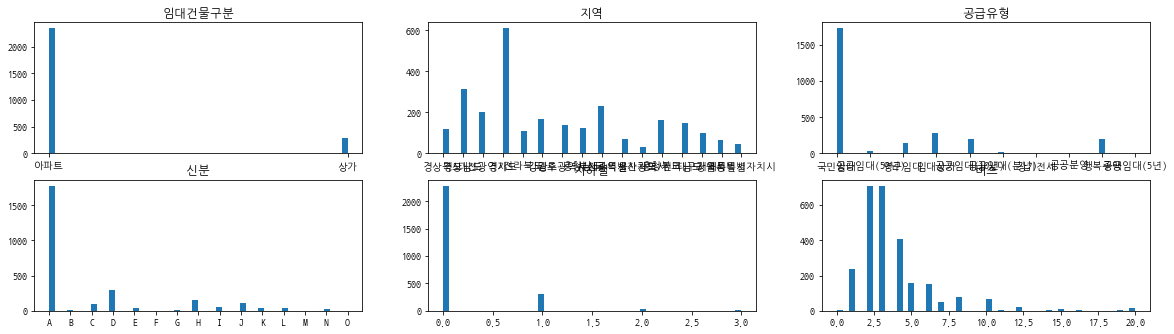

In [20]:
train_df = train[ [
     '임대건물구분', '지역', '공급유형', '신분',
    '지하철', '버스',]]

# 피처 각각에 대한 histogram을 출력합니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 14]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 3, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

plot_hist_each_column(train_df)

## 회귀분석에 이용할 피쳐 살펴보기 2. 산점도

 --> 전용면적별 세대수 이 자료가 되게 악랄하다. 전용면적별 세대수, 임대료, 보증금 때문에 자료가 왜곡이 심해지는 느낌이다. 

-->등록차량수랑 상관관계 있는거: 총세대수, 단지내 주차면수 정도??

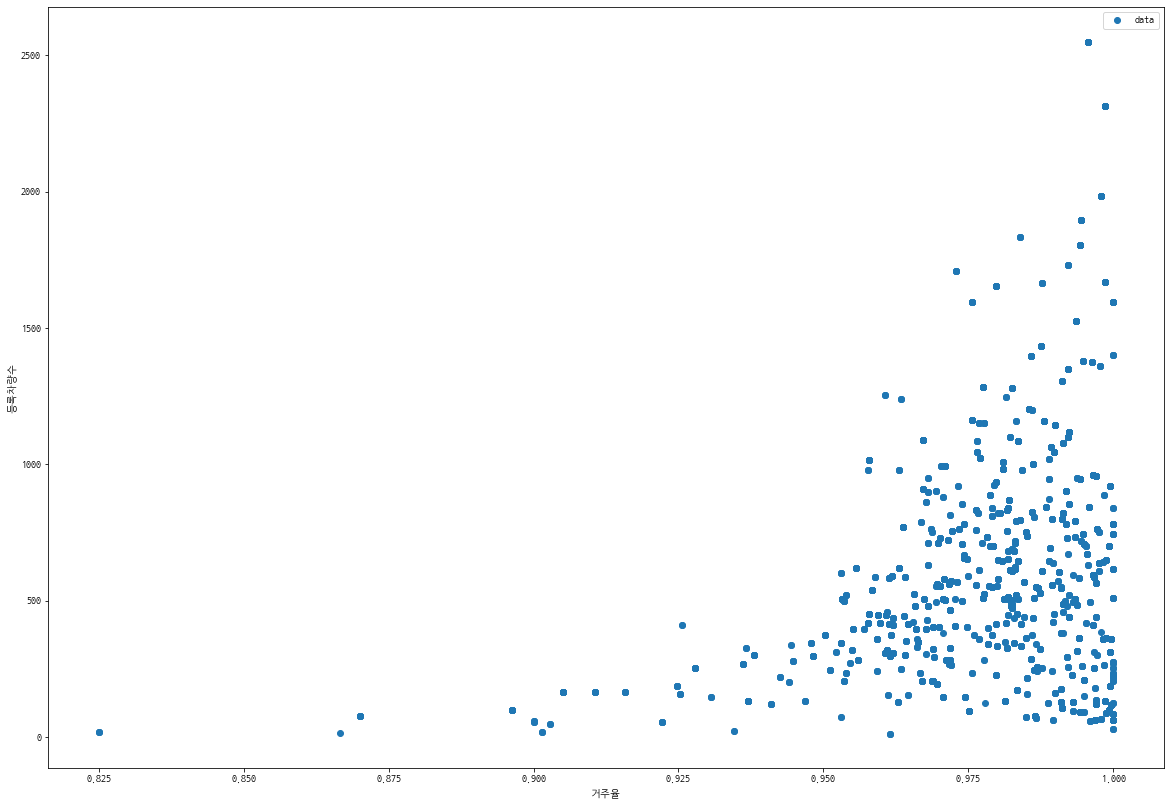

In [21]:
#거주율 등록차량수의 스캐터 플롯이 보고싶다. ---> 아무 관련이 없는거같다...

import matplotlib.pylab as plt

plt.scatter( train['거주율'], train['등록차량수'], label = "data")

plt.legend(loc = "best")
plt.xlabel('거주율')
plt.ylabel('등록차량수')
plt.show()

In [22]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,거주율
0,C2483,900,아파트,경상북도,국민임대,35.0,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.957778
1,C2483,900,아파트,경상북도,국민임대,35.0,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.957778
2,C2483,900,아파트,경상북도,국민임대,50.0,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.957778
3,C2483,900,아파트,경상북도,국민임대,50.0,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.957778
4,C2483,900,아파트,경상북도,국민임대,50.0,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.957778


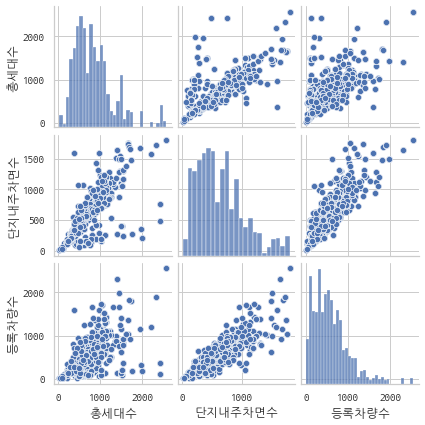

In [23]:
# 시각화로 파악하기
import seaborn as sns

sns.set(font="NanumGothicCoding",rc={"axes.unicode_minus":False}, style='whitegrid', context='notebook')
cols = ["총세대수", "지역", "공급유형", "신분", "단지내주차면수","등록차량수"]
sns.pairplot(train[cols], height=2);

# 전용면적별 세대수를 다 합하면 총세대수이므로 전용면적별 세대수는 굳이 그려볼 필요 없다. 

## 회귀분석에 이용할 피쳐 살펴보기 3. 상관계수

-->단지내 주차면수를 제외하고는.... 별로 상관관계가 보이지 않는다. 

In [24]:
# 상관계수 확인
train.corr()

# 단지내 주차면수가 가장 높다 (0.851280	)

,총세대수,전용면적,전용면적별세대수,공가수,지하철,버스,단지내주차면수,등록차량수,거주율
총세대수,1.000000,-0.060773,0.168208,0.103241,0.131384,0.038483,0.598347,0.423656,0.423309
전용면적,-0.060773,1.000000,-0.053361,-0.152485,-0.050397,0.016887,0.154033,0.279268,0.146944
전용면적별세대수,0.168208,-0.053361,1.000000,0.151090,-0.024246,0.054413,0.231223,0.188906,0.068013
공가수,0.103241,-0.152485,0.151090,1.000000,-0.110199,0.050872,0.292526,0.095454,-0.549457
지하철,0.131384,-0.050397,-0.024246,-0.110199,1.000000,0.106098,-0.028426,-0.063716,0.084294
버스,0.038483,0.016887,0.054413,0.050872,0.106098,1.000000,0.093102,0.117849,0.039212
단지내주차면수,0.598347,0.154033,0.231223,0.292526,-0.028426,0.093102,1.000000,0.851280,0.233896
등록차량수,0.423656,0.279268,0.188906,0.095454,-0.063716,0.117849,0.851280,1.000000,0.249270
거주율,0.423309,0.146944,0.068013,-0.549457,0.084294,0.039212,0.233896,0.249270,1.000000


## 회귀분석에 이용할 피쳐 살펴보기 4. 지역별, 공급유형별 중앙값과 평균값, 박스플롯



In [25]:
print(train.groupby('지역')['등록차량수'].median())

지역
강원도         333.0
경기도         752.0
경상남도        479.0
경상북도        562.0
광주광역시       713.0
대구광역시       744.0
대전광역시       373.0
부산광역시       345.0
서울특별시       793.0
세종특별자치시    1524.0
울산광역시       417.0
전라남도        408.0
전라북도        415.0
제주특별자치도     358.0
충청남도        209.0
충청북도        553.0
Name: 등록차량수, dtype: float64


In [26]:
train.groupby('지역')['등록차량수'].mean()

지역
강원도         410.903030
경기도         792.669951
경상남도        467.563694
경상북도        637.016949
광주광역시       726.949640
대구광역시       875.353535
대전광역시       644.123153
부산광역시       358.961207
서울특별시       888.253968
세종특별자치시    1293.553191
울산광역시       375.812500
전라남도        504.221477
전라북도        484.037383
제주특별자치도     405.072464
충청남도        264.728000
충청북도        561.577640
Name: 등록차량수, dtype: float64

In [27]:
train.groupby('공급유형')['등록차량수'].mean()

공급유형
공공분양         2315.000000
공공임대(10년)    1155.576355
공공임대(50년)     314.161290
공공임대(5년)      887.000000
공공임대(분납)     1413.000000
국민임대          641.447977
영구임대          385.228188
임대상가          166.712281
장기전세         1278.333333
행복주택          370.216749
Name: 등록차량수, dtype: float64

In [28]:
train.groupby('지역')['총세대수'].mean()

지역
강원도         524.533333
경기도         952.556650
경상남도        716.805732
경상북도        626.957627
광주광역시       773.697842
대구광역시       862.363636
대전광역시      1213.862069
부산광역시      1433.107759
서울특별시       777.111111
세종특별자치시    1256.297872
울산광역시       534.375000
전라남도        624.704698
전라북도        597.579439
제주특별자치도     548.275362
충청남도        623.560000
충청북도        699.074534
Name: 총세대수, dtype: float64

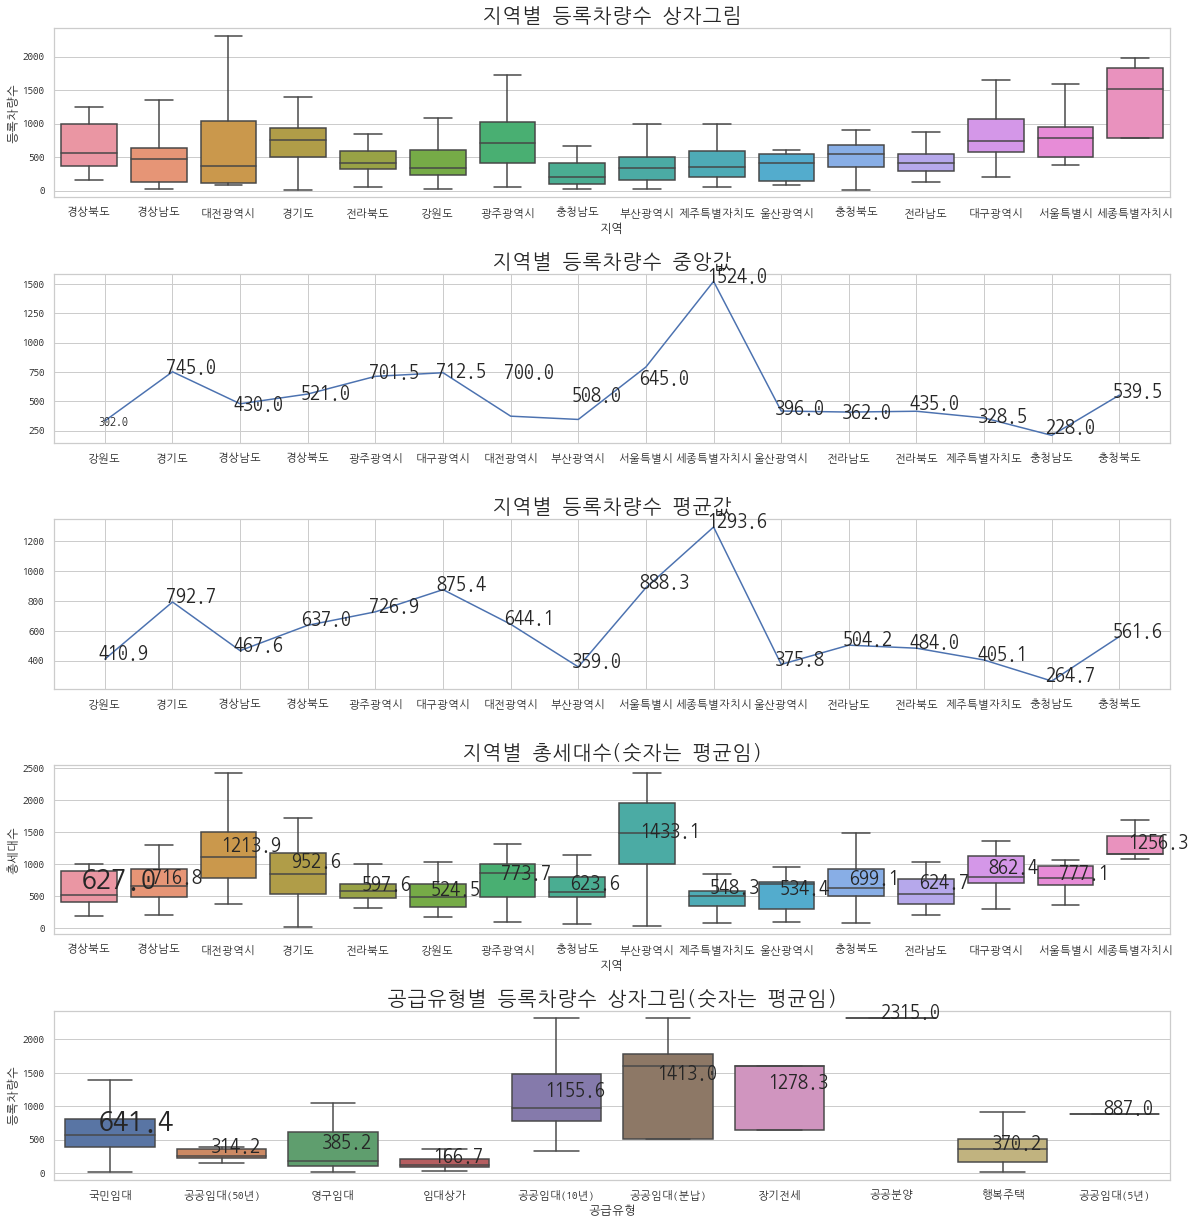

In [29]:
plt.figure(figsize=(20,20)) # 그래프 크기 조정
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.45)

plt.subplot(5,1,1) # 1행 2열의 첫 번째(1행, 1열) 그래프
g = sns.boxplot(x="지역", y="등록차량수", data=train, showfliers=False)
g.set_title('지역별 등록차량수 상자그림', size = 20)
g.set_xticklabels(g.get_xticklabels())

#----------------------------------------------------------------------------------------
plt.subplot(5,1,2)
plt.plot(train.groupby('지역')['등록차량수'].median())
plt.title('지역별 등록차량수 중앙값', size = 20)

Median_지역 = [ 302.0, 745.0, 430.0 ,521.0 ,701.5 ,712.5 ,700.0 ,508.0 ,645.0 ,1524.0 ,396.0 ,362.0 ,435.0 ,328.5 ,228.0 ,539.5]

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(Median_지역):
    plt.text(i-0.1, v + 0.005, str(np.round(v,3), )) # x 좌표, y 좌표, 텍스트를 표현한다.
    plt.rc('font', size=20)

Mean_지역 =       [410.903030
,792.669951
,467.563694
,637.016949
,726.949640
, 875.353535
,644.123153
,358.961207
,888.253968
,1293.553191
,375.812500
,504.221477
,484.037383
,405.072464
,264.728000
,561.577640]

#-------------------------------------------------------------------------------------------
plt.subplot(5,1,3)
plt.plot(train.groupby('지역')['등록차량수'].mean())
plt.title('지역별 등록차량수 평균값', size = 20)

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(Mean_지역):
    plt.text(i-0.1, v + 0.005, str(np.round(v,1), )) # x 좌표, y 좌표, 텍스트를 표현한다.
    plt.rc('font', size=20)

#-------------------------------------------------------------------------------------------

plt.subplot(5,1,4) # 1행 2열의 첫 번째(1행, 1열) 그래프
g = sns.boxplot(x="지역", y="총세대수", data=train, showfliers=False)
g.set_title('지역별 총세대수(숫자는 평균임)', size = 20)
g.set_xticklabels(g.get_xticklabels())

plt.rc('font', size=30)

Mean_총세대수 =  [626.957627,716.805732, 1213.862069, 952.556650, 597.579439, 524.533333, 773.697842, 623.560000, 1433.107759, 
            548.275362, 534.375000,  699.074534, 624.704698, 862.363636, 777.111111, 1256.297872 ]




# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(Mean_총세대수):
    plt.text(i-0.1, v + 0.005, str(np.round(v,1), )) # x 좌표, y 좌표, 텍스트를 표현한다.
    plt.rc('font', size=20)

#-------------------------------------------------------------------------------------------

plt.subplot(5,1,5) # 1행 2열의 첫 번째(1행, 1열) 그래프
g = sns.boxplot(x="공급유형", y="등록차량수", data=train, showfliers=False)
g.set_title('공급유형별 등록차량수 상자그림(숫자는 평균임)', size = 20)
g.set_xticklabels(g.get_xticklabels())

plt.rc('font', size=30)



Mean_공급유형 =  [641.447977, 314.161290, 385.228188,   166.712281, 
              1155.576355, 1413.000000,  1278.333333, 2315.000000,  370.216749, 887.000000]

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(Mean_공급유형):
    plt.text(i-0.1, v + 0.005, str(np.round(v,1), )) # x 좌표, y 좌표, 텍스트를 표현한다.
    plt.rc('font', size=20)

plt.show()

#1번 상자그림: 지역마다 분포가 제각각임. 
#2번, 3번 : 세종시, 경기도, 대구, 광주광역시 가 중앙값 평균값 높은편, 울산, 충청남도, 부산, 강원도는 낮은편
#4번 부산이나 대전은 총세대수가 높음에도 불구하고 등록차량수는 적다. 특히 부산은 지하철의 영향이 있어보인다. 
#세종시는 총세대수도 많고 등록차량수도 많다. 이건 가중치에 반영되야한다. 

## 지면상 싣지 않은 무의미한 분석 결과 요약

--> 유형별로 공공임대 vs 국민임대 vs 행복주택의 분류로 나누어 비교하였으나 이경우 data가 부족해셔 학습모델이 잘 작동하지 않음. 

--> 신분(자격유형)과 보증금, 임대료간의 상관관계는 미미하다. (보증금 임대료가 높다고 자격유형이 a가 되는것은 아님)

# 2) 예측

## 테스트 데이터셋 분리 --데이터 얼마 있지도 않은데 val(검증)데이터로 또나눌건지??

검증셋 만들지 말고 테스트데이터로 바로 테스트 하지?? --> test 데이터에 등록차량수가 없음. 그래서 test가 불가능;;;

In [30]:
# 데이터셋 분리 - train 80%, test 20%

from sklearn.model_selection import train_test_split
train, val = train_test_split(new_train,test_size=0.2, random_state=42)

In [31]:
new_train.columns

Index(['단지코드', '총세대수', '공급유형', '지역', '전용면적', '단지내주차면수', '지하철', '버스', '거주율',
       '면적_35.0', '면적_50.0', '면적_55.0', '면적_30.0', '면적_45.0', '면적_40.0',
       '면적_25.0', '면적_70.0', '면적_15.0', '면적_20.0', '면적_100.0', '면적_60.0',
       '면적_75.0', '면적_80.0', '면적_65.0', '등록차량수'],
      dtype='object')

In [32]:
new_test.columns

Index(['단지코드', '총세대수', '공급유형', '지역', '전용면적', '단지내주차면수', '지하철', '버스', '거주율',
       '면적_35.0', '면적_50.0', '면적_55.0', '면적_30.0', '면적_45.0', '면적_40.0',
       '면적_25.0', '면적_70.0', '면적_15.0', '면적_20.0', '면적_100.0', '면적_60.0',
       '면적_75.0', '면적_80.0', '면적_65.0'],
      dtype='object')

In [33]:
test.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
       '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '거주율'],
      dtype='object')

In [34]:
# 타겟 및 범주 확인
target = "등록차량수"

# 모델 학습을 위해 훈련용, 검증용 데이터를 각각 features와 target으로 분류
y_train = train[target]
X_train = train.drop(target, axis=1).iloc[:, 1:]
y_val = val[target]
X_val = val.drop(target, axis=1).iloc[:, 1:]
X_test = new_test.iloc[:, 1:]

# 데이터의 volume 확인
print("훈련용 데이터 확인 / features: {0}, target{1}".format(X_train.shape, y_train.shape))
print("검증용 데이터 확인 / features: {0}, target{1}".format(X_val.shape, y_val.shape))
print("테스트 데이터 확인 / features: {0}, target{1}".format(X_test.shape,0))

훈련용 데이터 확인 / features: (338, 23), target(338,)
검증용 데이터 확인 / features: (85, 23), target(85,)
테스트 데이터 확인 / features: (150, 23), target0


In [35]:
X_train.head()

,총세대수,공급유형,지역,전용면적,단지내주차면수,지하철,버스,거주율,면적_35.0,면적_50.0,...,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0
131,1072.0,국민임대,대전광역시,50.0,894.0,0.0,4.0,0.983209,0.0,602.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,809.0,공공임대(50년),강원도,35.0,264.0,0.0,6.0,0.998764,89.0,0.0,...,0.0,149.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,632.0,국민임대,충청북도,35.0,478.0,0.0,4.0,0.976266,458.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,690.0,국민임대,충청북도,30.0,694.0,0.0,3.0,0.969565,0.0,180.0,...,135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374,1124.0,공공임대(10년),대구광역시,45.0,1201.0,0.0,3.0,0.987544,0.0,0.0,...,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0


# 예측1: 다중선형회귀분석

선형회귀방식이 앙상불 같은 각종 부스트 방법에 비하여 성능이 떨어진다는 평판이 있지만, 자료의 수가 압도적으로 적을 경우 잘먹히는 경향이 있으므로 시도해 보는것도 좋을거 같다!!!!또한 결과를 해석하기도 쉽다!!! 

문제는...현재 가지고 잇는 자료의 피쳐들이 좀 많이 상관관계가 부족해서 새로운 피쳐를 개발해 내지 않는 이상 큰 성능은 기대하기 어렵겠다. 

## 만약 인코딩을 한다면 트레인 데이터는 fit_transform을 해야되고 테스트 데이터는 transform만해야한다.
근데 이때 파이프라인 만들어서 fit을 한다면  fit_transform, transform 을 구분할 필요가 없어진다. 하지만 지금은 파이프라인을 구성할 시간이 없다!! 허리업!!!(애초에 그냥 파이프라인으로 구성하지 ㅡㅡ...)

In [36]:
# 원핫인코딩
from category_encoders import OneHotEncoder

# 인코딩 객체 생성, gender 컬럼만 인코딩
encoder = OneHotEncoder()

# 훈련용 데이터 fit_transform
X_train_encoded = encoder.fit_transform(X_train)

# 검증용 데이터 : transform
X_val_encoded = encoder.transform(X_val)

#테스트 데이터 transform

X_test= encoder.transform(X_test)

## SelectKBest를 사용해 가장 효과적인 특성 K개를 골라보겠습니다.

target과 가장 correlated 된 features 를 k개 고르는 것이 목표입니다.
과적합을 줄일수 있는게 장점, 연산시간도 줄어드는 장점이 있습니다!

In [37]:

## f_regresison, SelectKBest
from sklearn.feature_selection import f_regression, SelectKBest

## selctor 정의합니다. SelectKBest는 몇가지 스코어함수를 사용할 수 있는데,
# 회귀에서는 f_regression을 주로 사용한다. 
selector = SelectKBest(score_func=f_regression, k=18)

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train_encoded , y_train)

## 테스트 데이터는 transform
X_val_selected = selector.transform(X_val_encoded)


X_train_selected.shape, X_val_selected.shape

((338, 18), (85, 18))

## 선택된 특성을 보겠습니다.

In [38]:
all_names = X_train_encoded.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['총세대수', '공급유형_3', '공급유형_5', '공급유형_6', '공급유형_7', '지역_2', '지역_7', '지역_10',
       '전용면적', '단지내주차면수', '거주율', '면적_35.0', '면적_50.0', '면적_55.0', '면적_45.0',
       '면적_70.0', '면적_100.0', '면적_80.0'],
      dtype='object')
Unselected names:  Index(['공급유형_1', '공급유형_2', '공급유형_4', '공급유형_8', '지역_1', '지역_3', '지역_4', '지역_5',
       '지역_6', '지역_8', '지역_9', '지역_11', '지역_12', '지역_13', '지역_14', '지역_15',
       '지역_16', '지하철', '버스', '면적_30.0', '면적_40.0', '면적_25.0', '면적_15.0',
       '면적_20.0', '면적_60.0', '면적_75.0', '면적_65.0'],
      dtype='object')


## 특성의 수 k 를 어떻게 결정하는게 좋을지 알아 보겠습니다

-->K값이 18일때가 가장 MAE가 낮고, R2값이 좋다.

1 features
Selected names:  Index(['단지내주차면수'], dtype='object')
Test MAE: $167
Test R2: 0.6984263125070884 

2 features
Selected names:  Index(['총세대수', '단지내주차면수'], dtype='object')
Test MAE: $162
Test R2: 0.7130446253119007 

3 features
Selected names:  Index(['총세대수', '단지내주차면수', '면적_55.0'], dtype='object')
Test MAE: $161
Test R2: 0.7082208401515107 

4 features
Selected names:  Index(['총세대수', '단지내주차면수', '면적_55.0', '면적_45.0'], dtype='object')
Test MAE: $160
Test R2: 0.7119021024185996 

5 features
Selected names:  Index(['총세대수', '단지내주차면수', '면적_55.0', '면적_45.0', '면적_70.0'], dtype='object')
Test MAE: $153
Test R2: 0.757494782843076 

6 features
Selected names:  Index(['총세대수', '공급유형_3', '단지내주차면수', '면적_55.0', '면적_45.0', '면적_70.0'], dtype='object')
Test MAE: $153
Test R2: 0.7650191711181128 

7 features
Selected names:  Index(['총세대수', '공급유형_3', '전용면적', '단지내주차면수', '면적_55.0', '면적_45.0', '면적_70.0'], dtype='object')
Test MAE: $158
Test R2: 0.7469976389372741 

8 features
Selected names:  Index(['총

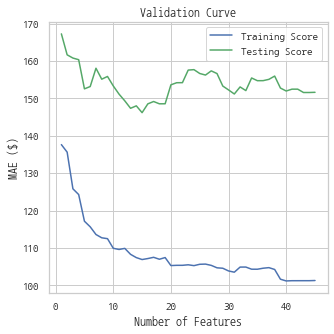

In [39]:
# features를 몇 개 선책하는 것이 좋은지 알아 봅시다.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

training = []
testing = []
ks = range(1, len(X_train_encoded.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_train_encoded.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train_encoded, y_train)
    X_val_selected = selector.transform(X_val_encoded)
    
    all_names = X_train_encoded.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_val_selected)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.figure(figsize=(5,5)) 
plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()
#결과를 보면 피쳐의 갯수에 따라서 어떻게 성능이 나오는 지를 시뮬레이션 해볼수가 있다

## 선형회귀 개시

In [40]:
from sklearn import linear_model
from math import sqrt
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# 회귀 분석 계수를 학습합니다 (회귀 모델 학습)
lr = linear_model.LinearRegression()
model_lr = lr.fit(X_train_selected, y_train)

In [41]:
print(model_lr.coef_)

[ 4.97947723e-01 -9.53251836e+01 -1.34191199e+02 -7.53426906e-01
  6.30298645e+01 -1.83189517e+02 -7.11122614e+01  5.62958528e+02
 -1.41416804e+02 -1.05500507e+01  2.23905839e+01 -9.51805115e+00
  3.29406005e+01 -5.19651765e+01  5.10424307e+00  3.46559556e+01
 -1.26495902e+02  2.98324642e+01  6.69170082e+01  6.68685617e+01
 -3.87751583e+01  1.84408578e+01  7.56766800e+01 -9.96468676e+01
 -1.58757489e+01  2.83378733e+00  5.81062691e-01 -6.64790578e+00
  5.93582307e+00  4.19841408e+02 -3.99292522e-01 -2.30526917e-01
 -9.14228538e-03 -4.76125758e-01 -9.32353344e-02 -3.30817871e-01
 -2.10817853e-01 -1.10335797e-01 -5.32173497e-01 -6.07499192e-01
 -6.64086850e+01 -4.03763319e+01  9.33286974e-01 -1.41622067e-01
  1.96965900e+00]


In [42]:
# 회귀 분석 모델을 평가합니다.
from sklearn.metrics import mean_absolute_error 

y_pred = model_lr .predict(X_val_selected)
mae_rl = mean_absolute_error(y_val, y_pred)
r2_rl = r2_score(y_val, y_pred)
testing.append(mae_rl)
print("mae_rl:", mae_rl, "r2_rl:", r2_rl)

mae_rl: 151.65338146463273 r2_rl: 0.72890651585332


# 예측2: ridge-regression

릿지회귀모델은 일반적으로 사용되는 선형회귀모델을 변형시킨 알고리즘입니다. 선형회귀모델 학습에 추가로 적절한 페널티를 부여해 더 일반화된 모델을 만들어내는 것이 목적입니다. 물론 성형회귀이므로.... 타겟과의 상관관계가 부족한 피쳐들로 구성해서 돌린다면 성능은 기대하기 힘들겟지요....

## RidgeCV를 통한 최적 패널티(alpha) 검증

In [43]:
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.05, 0.1, 0.2, 1.0, 10.0, 100.0]

ridge = RidgeCV(alphas=alphas, normalize=True, cv=5)
ridge.fit(X_train_selected, y_train)
y_pred = ridge.predict(X_val_selected)


print("alpha: ", ridge.alpha_)
mae_ridge = mean_absolute_error(y_val, y_pred)
r2_ridge  = r2_score(y_val, y_pred)
print("mae_ridge:", mae_ridge, "r2_ridge:", r2_ridge)


alpha:  1.0
mae_ridge: 146.76858585750588 r2_ridge: 0.7367703272292507


# 예측3: RandomForest

랜덤포레스트의 장점은 데이터셋에 있는 이상치에 덜 민감하고 하이퍼파라미터 튜닝이 많이 필요하지 않다는 점입니다. 하지만 일반적으로 앙상블 모델들이 그렇듯 결과를 해석하기가 까다롭습니다. 최적의 성능을 내보기 위해 그리드서치를 이용한 파라미터 튜닝도 겸해보겠습니다. 
베이스라인이 랜덤포레스트이지만, 파라미터들을 더 건들여서 좀더 좋은 성능을 내보도록 하겠습니다. 

In [44]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV
import time
#start = time.time() # 시작 시간 저장


#랜덤 포레스트의 parameter 범위를 정의한다.
#RF_params = {
#    'n_estimators': [50,100,150,200,300,500,1000],
#    'max_features': ['auto', 'sqrt'],
#    'max_depth' : [1,2,3,5,6,10],
#    'min_samples_leaf': [1, 2, 4],
#    'min_samples_split': [2, 3, 5, 10]}

 #GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.
#RF_model= {
#    'RF': GridSearchCV(
#        RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1
#        ).fit(X_train_selected, y_train).best_estimator_}

#print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

 #이미 GridSearchCV 돌려서 최적 파라미터 찾았는데 계속 돌릴 이유가 없잖아 ㅡㅡ. 

In [45]:
#RF_model

In [46]:
forest=RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=1000,
                       random_state=42)
                             
forest.fit(X_train_encoded , y_train)
y_pred =forest.predict(X_val_encoded )
mae_RF = mean_absolute_error(y_val, y_pred)
r2_RF = r2_score(y_val, y_pred)
print("mae_RF:", mae_RF, "r2_RF:", r2_RF)

mae_RF: 154.97455346133836 r2_RF: 0.737111776106499


In [47]:
importances = pd.Series(forest.feature_importances_, selected_names)
importances

총세대수        2.502192e-02
공급유형_1      1.917983e-03
공급유형_2      5.341503e-04
공급유형_3      8.039452e-03
공급유형_4      0.000000e+00
공급유형_5      9.660381e-05
공급유형_6      6.469151e-04
공급유형_7      0.000000e+00
공급유형_8      0.000000e+00
지역_1        6.804426e-04
지역_2        1.707602e-04
지역_3        5.765525e-04
지역_4        4.361497e-04
지역_5        7.854239e-04
지역_6        1.761327e-04
지역_7        2.441874e-03
지역_8        5.554784e-04
지역_9        4.732542e-04
지역_10       8.325136e-04
지역_11       2.068100e-04
지역_12       2.135370e-03
지역_13       9.254323e-05
지역_14       1.037288e-03
지역_15       7.958093e-05
지역_16       6.811547e-06
전용면적        2.113254e-02
단지내주차면수     7.632160e-01
지하철         1.111948e-03
버스          2.048162e-02
거주율         4.154736e-02
면적_35.0     2.948747e-02
면적_50.0     1.333104e-02
면적_55.0     1.052123e-02
면적_30.0     3.711681e-03
면적_45.0     2.273240e-02
면적_40.0     2.583349e-04
면적_25.0     6.895848e-03
면적_70.0     1.229615e-02
면적_15.0     1.965580e-04
면적_20.0     6.685651e-04


# 예측4: xgboost

XGBoost는 랜덤포레스트와 마찬가지로 트리기반 모델입니다. 특히 학습을 진행할때 오분류된 데이터에 가중치를 부여해 성능을 높이고자 하는 모델입니다. 마찬가지로 GridSearchCV를 통해 죄적의 파라미터를 찾아서 모델링을 진행해 보았습니다....

In [48]:
import xgboost as xgb 
#start = time.time() # 시작 시간 저장

# xgboost parmeter space를 정의한다.
#XGB_params = {
#    'min_child_weight': [1,3, 5,10],
#    'gamma': [0.3,0.5, 1, 1.5, 2, 5],
#    'subsample': [0.6, 0.8, 1.0],
#    'colsample_bytree': [0.6, 0.8, 1.0],
#    'max_depth': [3, 4, 5,7,10]}
# GridSearchCV를 통해 parameter를 탐색하게 정의한다.
#XGB_model = GridSearchCV(xgb.XGBRegressor(random_state=42),
#    param_grid=XGB_params, n_jobs=-1)

# 모델 학습
#XGB_model.fit(X_train_selected, y_train)

#print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

#최적의 파라미터를 찾았으므로 잠궈둔다. 

In [49]:
#XGB_model.best_params_

In [50]:
XGB_model = xgb.XGBRegressor(colsample_bytree= 1.0,
 gamma= 2,
 max_depth= 5,
 min_child_weight= 3,
 subsample= 0.6,n_jobs=-1,random_state=42)

In [51]:
XGB_model.fit(X_train_selected, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
y_pred = XGB_model.predict(X_val_selected)
mae_xgboost = mean_absolute_error(y_val, y_pred)

r2_xgboost = r2_score(y_val, y_pred)
print("mae_xgboost:", mae_xgboost, "r2_xgboost:", r2_xgboost)

mae_xgboost: 135.64211210363052 r2_xgboost: 0.7694268163032836


## 3) 분석 요약

In [53]:

#다중선형회귀분석
print("mae_rl:", mae_rl, "r2_rl:", r2_rl)
print("-----------------------------------")
#릿지회귀분석
print("mae_ridge:", mae_ridge, "r2_ridge:", r2_ridge)
print("-----------------------------------")
#랜덤포레스트 분석
print("mae_RF:", mae_RF, "r2_RF:", r2_RF)
print("-----------------------------------")
#XGBboost 분석
print("mae_xgboost:", mae_xgboost, "r2_xgboost:", r2_xgboost)


mae_rl: 151.65338146463273 r2_rl: 0.72890651585332
-----------------------------------
mae_ridge: 146.76858585750588 r2_ridge: 0.7367703272292507
-----------------------------------
mae_RF: 154.97455346133836 r2_RF: 0.737111776106499
-----------------------------------
mae_xgboost: 135.64211210363052 r2_xgboost: 0.7694268163032836


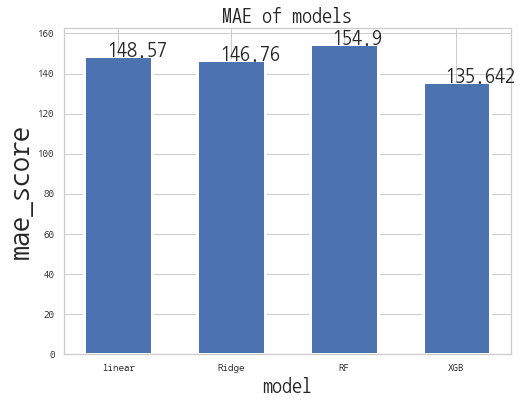

In [54]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
mae_score = [ 148.57, 146.76, 154.9, 135.642]
x_lab = ['linear', 'Ridge', 'RF', 'XGB']

fig = plt.figure(figsize=(8, 6))
plt.bar(x, mae_score,width=0.6,linewidth=3)
plt.title('MAE of models', fontsize=20)
plt.xticks(x, x_lab)
plt.xlabel('model', fontsize=20)
plt.ylabel('mae_score', fontsize=30)
#plt.ylim(0,0.5)

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(mae_score):
    plt.text(i-0.1, v + 0.01, str(np.round(v,3), )) # x 좌표, y 좌표, 텍스트를 표현한다.
plt.rc('font', size=30)
  
plt.show()

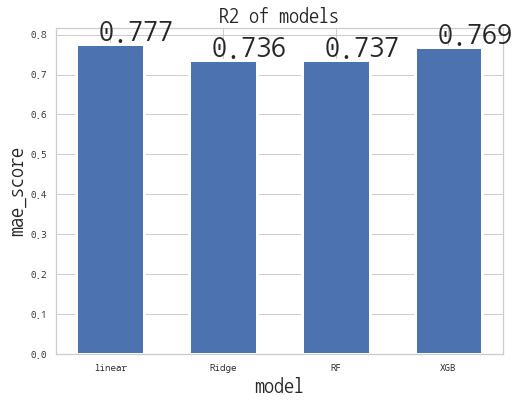

In [55]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
R2_score = [ 0.7772,0.736, 0.7371, 0.7694]
x_lab = ['linear', 'Ridge', 'RF', 'XGB']


fig = plt.figure(figsize=(8, 6))
plt.bar(x, R2_score,width=0.6,linewidth=3)
plt.title('R2 of models', fontsize=20)
plt.xticks(x, x_lab)
plt.xlabel('model', fontsize=20)
plt.ylabel('mae_score', fontsize=20)
#plt.ylim(0,0.5)

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(R2_score):
    plt.text(i-0.1, v + 0.01, str(np.round(v,3))) # x 좌표, y 좌표, 텍스트를 표현한다.
    plt.rc('font', size=30)
    
plt.show()

# 3. 결과 해석 및 평가

## 1) 충격과 공포의 참담한 결과지만....맛녀석의 한입만이 아니고서야 첫술에 배부를순 없지.

베이스라인인 랜덤 포레스트의 결과:

mae_RF: 156.07035294117645 r2_RF: 0.722398709107971
-----------------------------------

--------------------------------------


직접 분석해고 굴린 모델의 결과:

mae_rl: 151.65338146463273 r2_rl: 0.72890651585332
-----------------------------------
mae_ridge: 146.76858585750588 r2_ridge: 0.7367703272292507
-----------------------------------
mae_RF: 154.97455346133836 r2_RF: 0.737111776106499
-----------------------------------
mae_xgboost: 135.64211210363052 r2_xgboost: 0.7694268163032836
-----------------------------------


이 시간과 전기세를 들여서 이런 수준의 결과 밖에 못낸거면.... 그냥 베이스라인을 쓰는게 더 좋았을수도...?

## 2) 머신러닝 모델 해석

# 다중선형회귀

20 features
Selected names:  Index(['총세대수', '공급유형_공공임대(10년)', '공급유형_영구임대', '공급유형_행복주택', '공급유형_공공분양',
       '지역_강원도', '지역_충청남도', '지역_경기도', '지역_세종특별자치시', '전용면적', '단지내주차면수',
       '버스_6.0', '거주율', '면적_35.0', '면적_50.0', '면적_55.0', '면적_45.0', '면적_70.0',
       '면적_100.0', '면적_80.0'],
      dtype='object')
Test MAE: $148
Test R2: 0.777

이들의 '등록된차량수'와의 상관관계

[ 3.59984164e-01 -9.18855774e+01 -1.70981881e+02  2.55395800e+01
  1.09635392e+02 -1.90421103e+02 -5.31943049e+01  5.18098076e+02
 -1.46790182e+02 -4.07282189e+00  1.65165725e+01 -1.30759127e+01
  4.06017410e+01 -3.86091372e+01 -1.04174951e+01  4.39800026e+01
 -1.31948697e+02  3.85156356e+00  7.18394519e+01  7.18636802e+01
 -4.09406239e+01  2.31278349e+01  5.70919910e+01 -9.80092281e+01
  8.20107859e+00  2.75580261e+00  5.95088967e-01  8.48780433e+00
 -1.61812898e+01  1.13470782e+01 -3.65359265e+00 -5.11204764e+00
  8.61326002e+01 -3.75308536e+01 -4.04708333e+01 -5.59870325e+01
  4.88807456e+00  3.82039799e+01 -2.40325342e+01  8.87367348e+01
 -1.12166003e+01 -2.24772024e+01 -2.11770308e+00 -2.09689234e+02
  5.05863153e+01  2.58753686e+02 -7.02483206e+01 -4.84190288e+01
  5.44247864e+02 -2.81296997e-01 -9.76235730e-02  7.66658544e-02
 -3.38538488e-01  5.00816465e-02 -1.72799486e-01 -8.30867567e-02
 -9.39792902e-02 -4.52540750e-01 -5.13842608e-01 -4.32693150e+01
 -3.28296735e+01  1.73637889e+00  3.27126014e-02  2.00062462e+00]

총세대수가 1이 늘때 등록차량수는 0.497948이 늘어나고 전용면적이 1이 늘어날때 등록차량수는 2.833787 늘어난다...요런식으로 해석가능.
야 근데 거주율은 웰케큼? 거주율100% 일때 등록차량수 419.841408 늘어난다는 뜻 아님?? 1증가마다 늘어나는거니까.

In [56]:
coefficients = model_lr.coef_
pd.Series(coefficients, selected_names)

총세대수          0.497948
공급유형_1      -95.325184
공급유형_2     -134.191199
공급유형_3       -0.753427
공급유형_4       63.029864
공급유형_5     -183.189517
공급유형_6      -71.112261
공급유형_7      562.958528
공급유형_8     -141.416804
지역_1        -10.550051
지역_2         22.390584
지역_3         -9.518051
지역_4         32.940600
지역_5        -51.965177
지역_6          5.104243
지역_7         34.655956
지역_8       -126.495902
지역_9         29.832464
지역_10        66.917008
지역_11        66.868562
지역_12       -38.775158
지역_13        18.440858
지역_14        75.676680
지역_15       -99.646868
지역_16       -15.875749
전용면적          2.833787
단지내주차면수       0.581063
지하철          -6.647906
버스            5.935823
거주율         419.841408
면적_35.0      -0.399293
면적_50.0      -0.230527
면적_55.0      -0.009142
면적_30.0      -0.476126
면적_45.0      -0.093235
면적_40.0      -0.330818
면적_25.0      -0.210818
면적_70.0      -0.110336
면적_15.0      -0.532173
면적_20.0      -0.607499
면적_100.0    -66.408685
면적_60.0     -40.376332
면적_75.0       0.933287
면적_80.0    

# ridge-regression

--> 해석 요령은 다중선형회귀와 동일하므로 생략하겠다. 

In [57]:
coefficients = ridge.coef_
pd.Series(coefficients, selected_names)

총세대수          0.172446
공급유형_1        2.322206
공급유형_2      -78.844358
공급유형_3      106.693757
공급유형_4      129.025468
공급유형_5     -102.978934
공급유형_6      -32.644126
공급유형_7      463.546239
공급유형_8      -14.841759
지역_1         32.851949
지역_2        -28.681500
지역_3         -3.573192
지역_4         38.755005
지역_5        -61.783318
지역_6        -19.222613
지역_7         42.109775
지역_8        -50.220882
지역_9        -10.242010
지역_10       126.163101
지역_11        33.620730
지역_12       -32.519776
지역_13       -25.992119
지역_14        47.210681
지역_15       -64.903925
지역_16         7.568582
전용면적          1.968230
단지내주차면수       0.247636
지하철          -9.083880
버스            3.857892
거주율         829.004844
면적_35.0       0.060949
면적_50.0       0.159723
면적_55.0       0.267041
면적_30.0      -0.029650
면적_45.0       0.229476
면적_40.0       0.095277
면적_25.0       0.031139
면적_70.0       0.387121
면적_15.0       0.013580
면적_20.0      -0.007711
면적_100.0    -86.383886
면적_60.0     -38.786415
면적_75.0       1.422033
면적_80.0    

## RandomForest


In [58]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

In [59]:
print(X_train_encoded.columns)
feature = '총세대수'

Index(['총세대수', '공급유형_1', '공급유형_2', '공급유형_3', '공급유형_4', '공급유형_5', '공급유형_6',
       '공급유형_7', '공급유형_8', '지역_1', '지역_2', '지역_3', '지역_4', '지역_5', '지역_6',
       '지역_7', '지역_8', '지역_9', '지역_10', '지역_11', '지역_12', '지역_13', '지역_14',
       '지역_15', '지역_16', '전용면적', '단지내주차면수', '지하철', '버스', '거주율', '면적_35.0',
       '면적_50.0', '면적_55.0', '면적_30.0', '면적_45.0', '면적_40.0', '면적_25.0',
       '면적_70.0', '면적_15.0', '면적_20.0', '면적_100.0', '면적_60.0', '면적_75.0',
       '면적_80.0', '면적_65.0'],
      dtype='object')


In [60]:
len(X_train_encoded.columns)

45

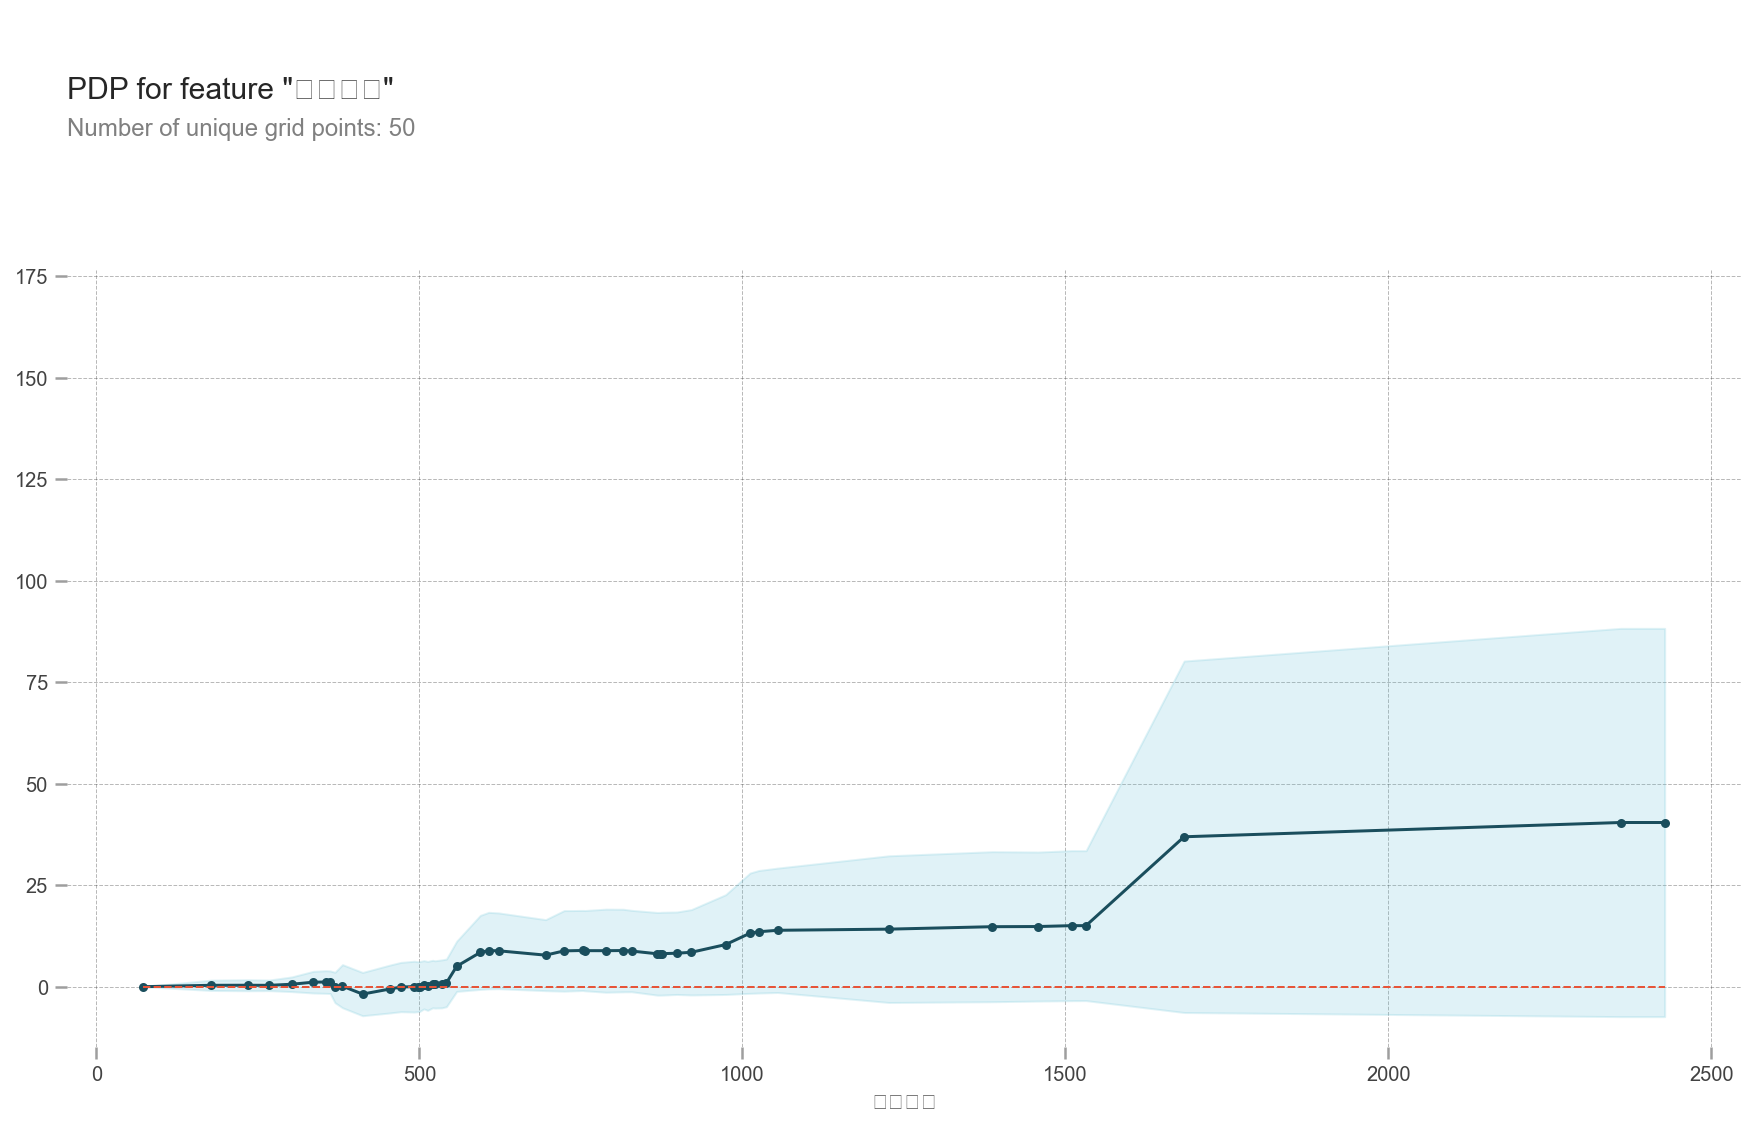

In [61]:
from pdpbox.pdp import pdp_isolate, pdp_plot

isolated = pdp_isolate(
    model=forest, 
    dataset=X_val_encoded , 
    model_features=X_val_encoded .columns,
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=50 # default=10
)
pdp_plot(isolated, feature_name=feature);

## XGBoost

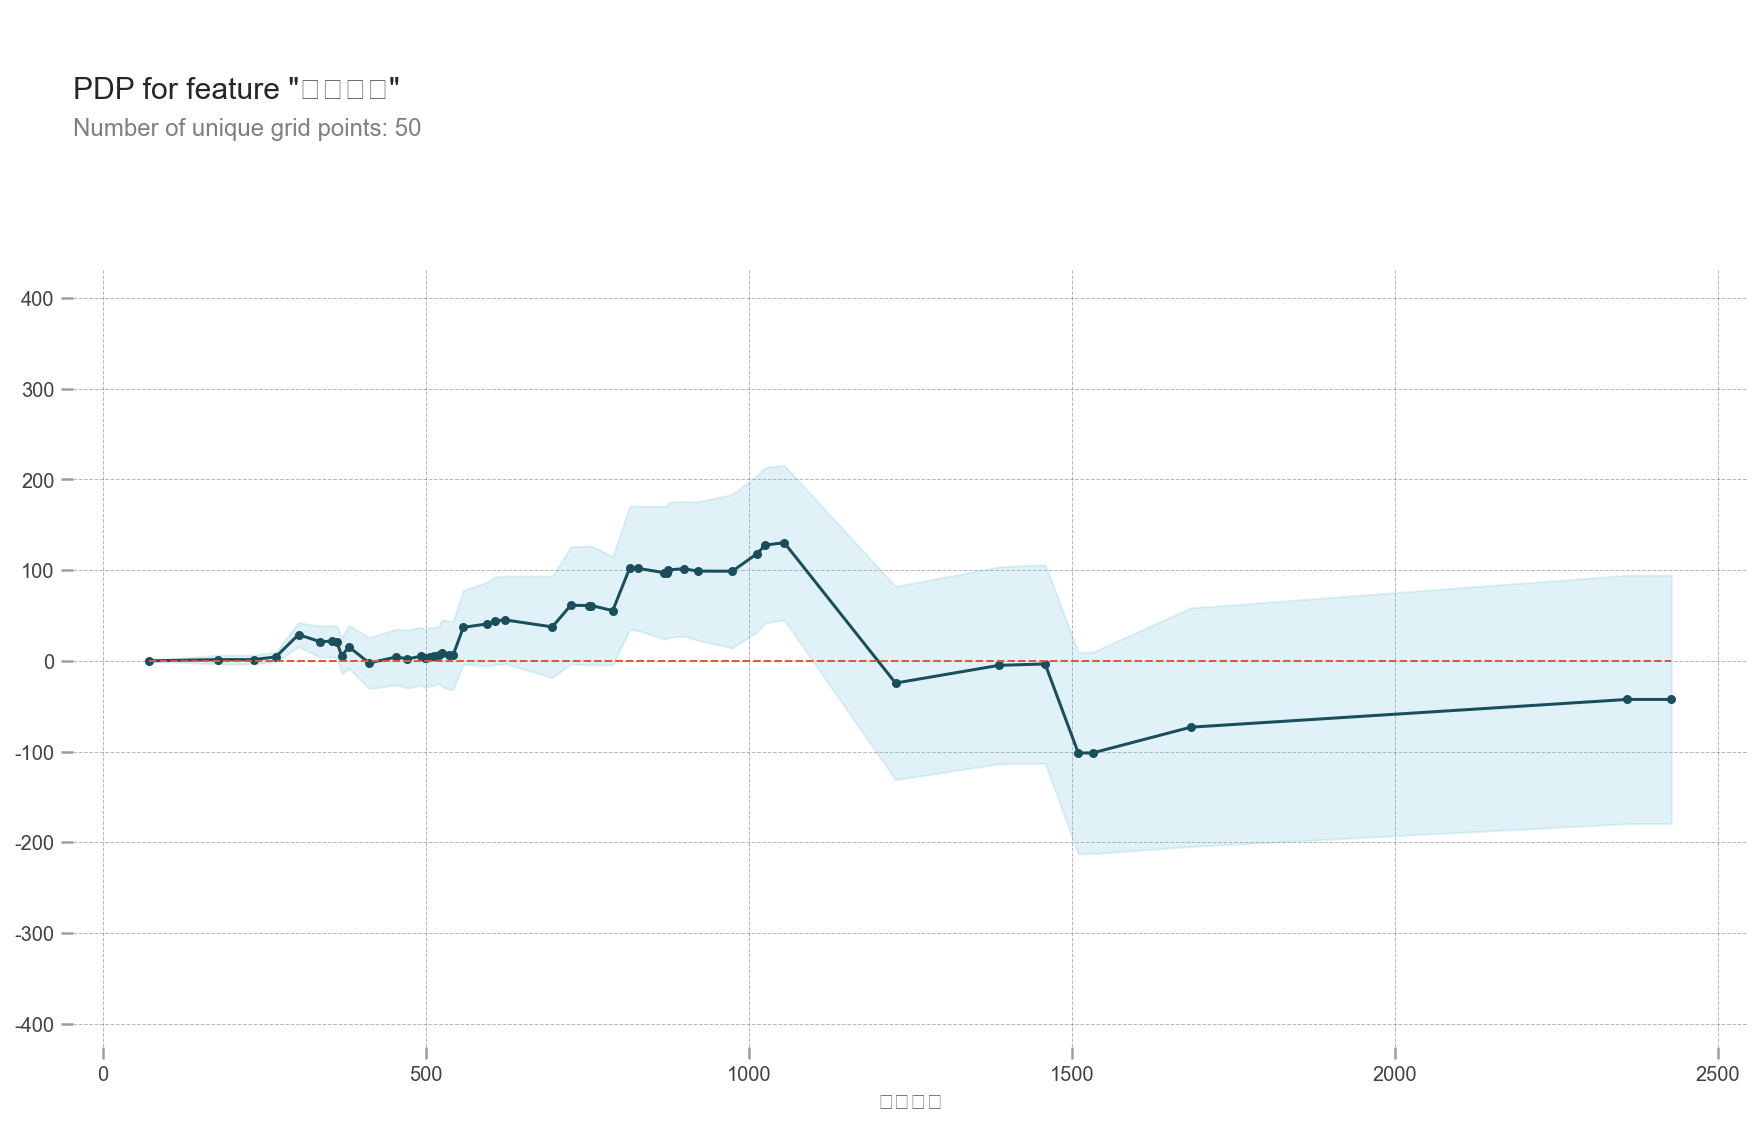

In [62]:
isolated = pdp_isolate(
    model=XGB_model, 
    dataset=X_val_encoded , 
    model_features=X_val_encoded .columns,
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=50 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [63]:
row = X_train_encoded.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

,총세대수,공급유형_1,공급유형_2,공급유형_3,공급유형_4,공급유형_5,공급유형_6,공급유형_7,공급유형_8,지역_1,...,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0
31,809.0,0,1,0,0,0,0,0,0,0,...,0.0,149.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# 실제 집값
y_val.iloc[[1]] # 2번째 데이터를 사용했습니다


280    1084.0
Name: 등록차량수, dtype: float64

In [65]:
# 모델 예측값
XGB_model.predict(row)

array([645.8847], dtype=float32)

In [66]:
# 모델이 이렇게 예측한 이유를 알기 위하여
# SHAP Force Plot을 그려보겠습니다.

import shap

explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row)

#빨간색이 영향도가 높은 것이고, 파란색이 영향도가 낮은 것이다. 

In [67]:
shap_values = explainer.shap_values(X_test.iloc[:])
shap.force_plot(explainer.expected_value, shap_values,X_test.iloc[:])


 해당 변수가 빨간색을 띄면 target(price)에 대해 양의 영향력이 존재하는 것이고, 파란색을 띄면 음의 영향력이 존재하는 것이다.
 이건...뭐 짬뽕이라 해석이 안된다....;;

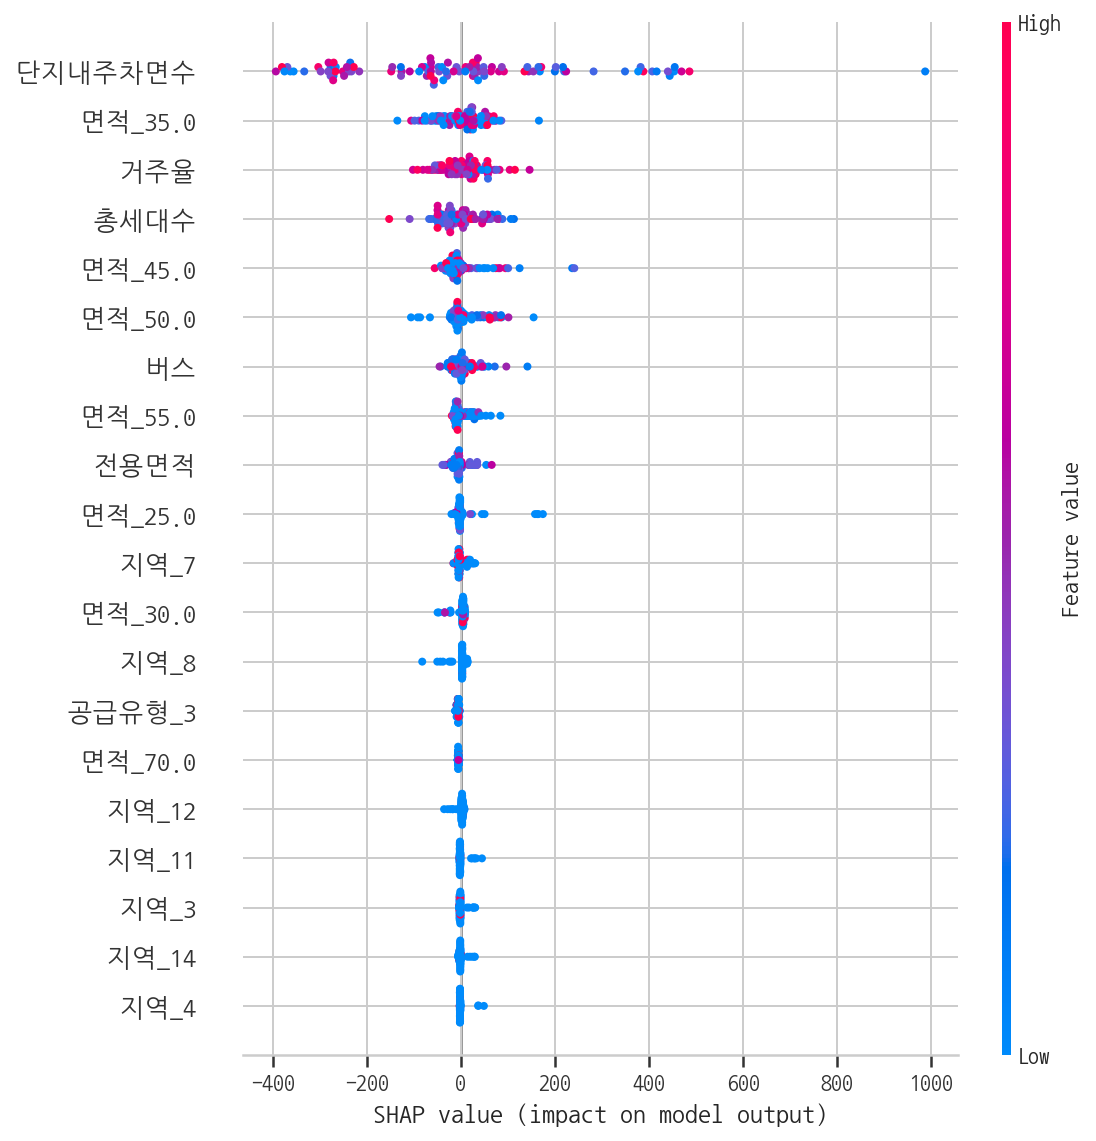

In [68]:
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.summary_plot(shap_values,X_train_encoded.iloc[:100])

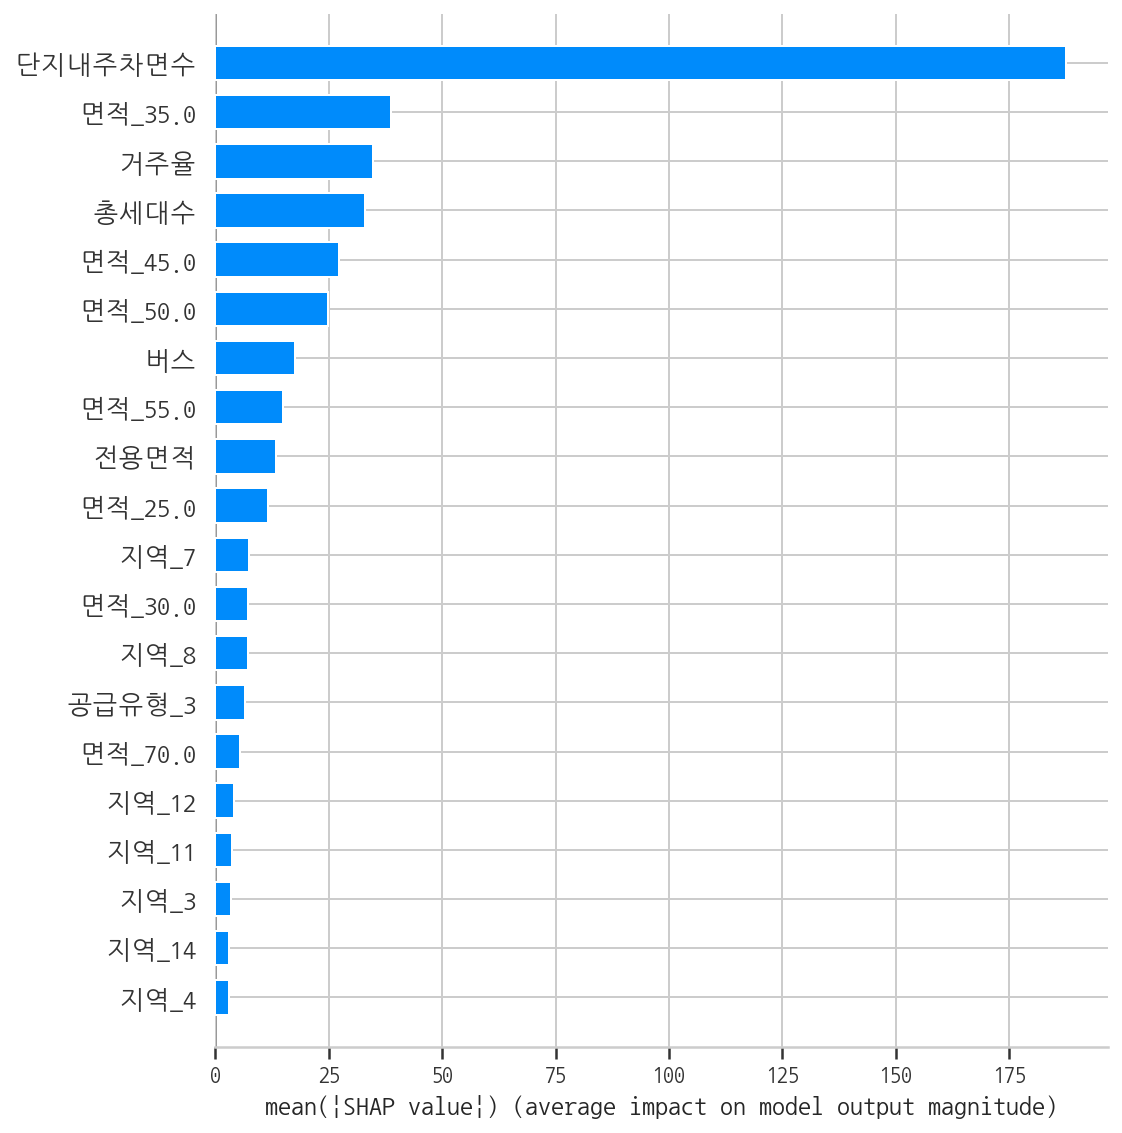

In [69]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")
# 이는 각 변수의 shap value에 절대값을 취한 것으로 변수의 평균적인 영향력을 보여준다. 
# 큰 영향력을 보일 수록, target과 관계성(인과관계X)이 크다는 것이다. 즉, 변수의 중요도와 비슷한 개념이다. 

# 4. 결어

부족한 것이 많은 분석이다. 

- 데이터중에 나이대 별 남녀 성비에 관한 sheet도 있었으나 아직 이렇다 할 인사이트를 얻지못해 방치해뒀다. 피쳐 엔지니어링에 관한 더 고민이 필요하겠다. 

- 공급유형별로도 분명 등록차량대수에 많은 차이가 발생할 것이었으나 이를 가중치에 넣어 반영하지 못했다. 특히 '행복주택'은 상대적으로 차량보유대수가 적을것이라는 추론이 가능했지만, 이를 데이터 분석으로 구현하지는 못했다. 

-지역별로도 차량등록대수에 차이가 발생할 수 있음을 데이터를 통해 확인했으나 가중치를 반영해 주지 못했다. 특히 총세대수와 등록차량대수가 비례하는 세종시와 비례하지 못하는 부산은 가중치 조정이 필요했으나 이를 반영하지 못했다. 